In [1]:
import torch, torchvision, PIL, numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL
import matplotlib.patches as patches
import glob
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


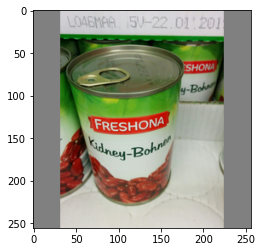

In [3]:
#test to make sure i have the right directory
plt.imshow(PIL.Image.open('/content/drive/MyDrive/freiburg_groceries_dataset/images/BEANS/BEANS0000.png'))

In [4]:
ds_dir = '/content/drive/MyDrive/freiburg_groceries_dataset/images'

In [5]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((299,299)), torchvision.transforms.ToTensor()]) 
ds = torchvision.datasets.ImageFolder(ds_dir, transform=xform)

In [127]:
n_all = len(ds)
n_train = 4000
n_test = n_all - n_train

rng = torch.Generator().manual_seed(291)
ds_train, ds_test = torch.utils.data.random_split(ds, [n_train, n_test], rng)

0


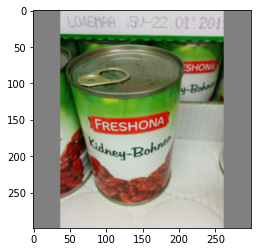

In [128]:
plt.imshow(ds[0][0].permute(1,2,0))
print(ds[0][1])

In [129]:
len(ds_train)

4000

In [142]:
loader_train = torch.utils.data.DataLoader(ds_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(ds_test, batch_size = 1, shuffle=True)

Either the above code box or the below code box

In [143]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [144]:
model = torchvision.models.inception_v3(pretrained=True)
set_parameter_requires_grad(model, True)
# Handle the auxilary net
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = torch.nn.Linear(num_ftrs, 25)
# Handle the primary net
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs,25)

In [145]:
def init_weights(m):
    if type(m) == torch.nn.Conv2d: #changed from torch.nn.Linear
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

model.fc.apply(init_weights)

Linear(in_features=2048, out_features=25, bias=True)

In [146]:
device = torch.device('cuda:0')
model = model.to(device)

In [147]:
update_parm = []
for name,param in model.named_parameters():
        if param.requires_grad == True:
            update_parm.append(param)
            print("\t",name)

optimizer = torch.optim.SGD(update_parm, lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [148]:
criterion = torch.nn.CrossEntropyLoss()

In [149]:
def run_test(model):
    nsamples_test = len(ds_test)
    loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device)
            outs = model(samples) #tried (samples[None, ...]
            loss = criterion(outs, labels)
            _, preds = torch.max(outs, 1)
            loss += loss.item() * samples.size(0)
            correct += torch.sum(preds == labels.data)
    return loss / nsamples_test, correct / nsamples_test

In [150]:
def run_train(model, opt, sched):
    nsamples_train = len(ds_train)
    loss_sofar, correct_sofar = 0, 0
    model.train()
    with torch.enable_grad():
        for samples, labels in loader_train:
            samples = samples.to(device)
            labels = labels.to(device)
            opt.zero_grad()
            outs, aux_outputs = model(samples) 
            _, preds = torch.max(outs, 1)
            loss = criterion(outs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss + 0.4*loss2
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            correct_sofar += torch.sum(preds == labels.data)
    sched.step()
    return loss_sofar / nsamples_train, correct_sofar / nsamples_train

In [151]:
def run_all(model, optimizer, scheduler, n_epochs):
    for epoch in range(n_epochs):
        loss_train, acc_train = run_train(model, optimizer, scheduler)
        loss_test, acc_test = run_test(model)
        print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f} ")
        

In [152]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 3.8720 acc 0.1770, test loss 0.0078 acc 0.3590 
epoch 1: train loss 3.1568 acc 0.2990, test loss 0.0042 acc 0.4657 
epoch 2: train loss 2.8933 acc 0.3510, test loss 0.0043 acc 0.5121 
epoch 3: train loss 2.7107 acc 0.3890, test loss 0.0030 acc 0.5111 
epoch 4: train loss 2.6301 acc 0.4003, test loss 0.0034 acc 0.5428 
epoch 5: train loss 2.4646 acc 0.4563, test loss 0.0062 acc 0.5755 
epoch 6: train loss 2.4267 acc 0.4540, test loss 0.0074 acc 0.5649 
epoch 7: train loss 2.4236 acc 0.4480, test loss 0.0073 acc 0.5671 
epoch 8: train loss 2.4085 acc 0.4520, test loss 0.0019 acc 0.5808 
epoch 9: train loss 2.4506 acc 0.4433, test loss 0.0044 acc 0.5924 


In [153]:
import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

model = torchvision.models.mobilenet_v3_small(pretrained=True)
model.eval()
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model, example)
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model.save("model.pt")